# London Smart Meters
Time series data, example used in Chapter 2 of 'Modern Time Series Forecasting With Python" (2ed)

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
from startup import np, pd, plt, sns, sm, smf, os, Path

In [7]:
from mattmcd.io import pg_engine

In [3]:
import kagglehub

In [5]:
# Doc: https://www.kaggle.com/datasets/jeanmidev/smart-meters-in-london
path = kagglehub.dataset_download("jeanmidev/smart-meters-in-london")

print("Path to dataset files:", path)

Path to dataset files: /Users/mattmcd/.cache/kagglehub/datasets/jeanmidev/smart-meters-in-london/versions/21


In [60]:
os.listdir(path)

['halfhourly_dataset',
 'hhblock_dataset',
 'darksky_parameters_documentation.html',
 'acorn_details.csv',
 'uk_bank_holidays.csv',
 'daily_dataset',
 'weather_daily_darksky.csv',
 'informations_households.csv',
 'daily_dataset.csv',
 'weather_hourly_darksky.csv']

In [70]:
class HalfHourlyData:
    def __init__(self, cache_root):
        self.cache_root = cache_root
        self.hh_root = Path(path) / 'hhblock_dataset' / 'hhblock_dataset'
        self.info_path = Path(path) / 'informations_households.csv'
        self.df_info = pd.read_csv(self.info_path)

    @property
    def blocks(self):
        block_numbers = sorted(
            [int(f.lstrip('block_').rstrip('.csv') )
             for f in os.listdir(self.hh_root)]
        )
        return block_numbers

    def get_block(self, block_number):
        df = pd.read_csv(self.hh_root / f'block_{block_number}.csv').assign(
            day=lambda x: pd.to_datetime(x['day'])
        )
        return df

    def get_id(self, lcl_ids):
        df_i = self.df_info
        ind_id = df_i['LCLid'].isin(lcl_ids)
        blocks = self.df_info.loc[ind_id, 'file'].str.rstrip(
            '.csv').str.lstrip('block_').unique()
        df_b = pd.concat([self.get_block(b) for b in blocks])
        return df_b.loc[df_b['LCLid'].isin(lcl_ids), :]


In [71]:
hh_data = HalfHourlyData(path)

In [83]:
hh_data.df_info.describe()

,LCLid,stdorToU,Acorn,Acorn_grouped,file
count,5566,5566,5566,5566,5566
unique,5566,2,19,5,112
top,MAC005492,Std,ACORN-E,Affluent,block_0
freq,1,4443,1567,2192,50


In [84]:
df_a = pd.concat([hh_data.get_block(n) for n in hh_data.blocks])

In [102]:
df_g = pd.merge(
    df_a.set_index(['LCLid', 'day']).sum(axis=1).reset_index(),
    hh_data.df_info,
    on='LCLid',
)

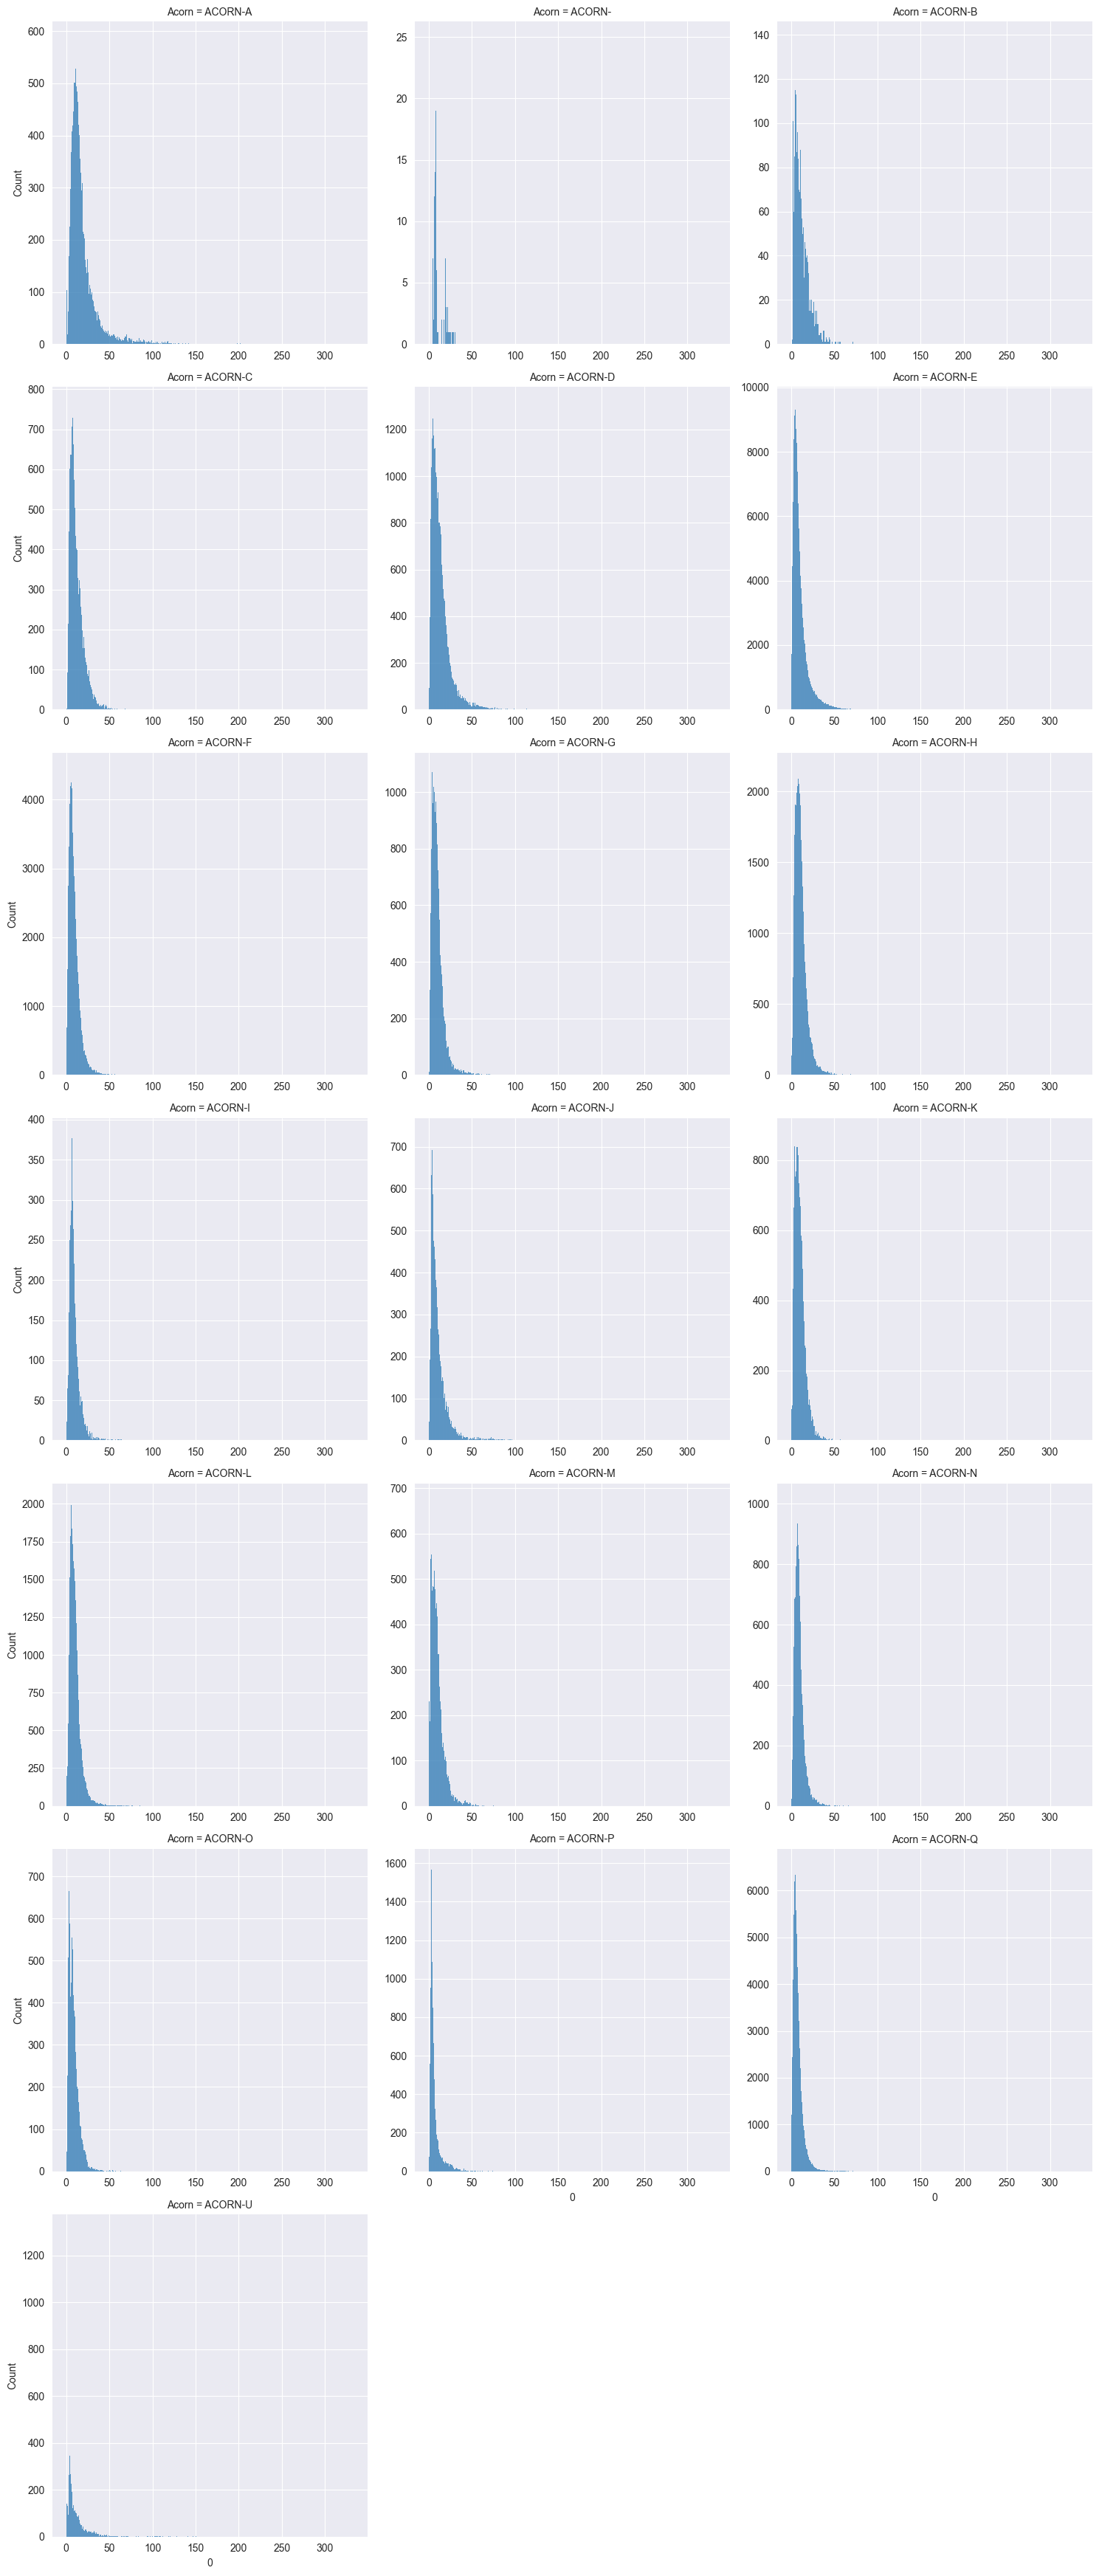

In [106]:
sns.displot(df_g, x=0, col='Acorn', col_wrap=3, facet_kws=dict(sharex=False, sharey=False))

In [78]:
lcl_ids = ['MAC000002', 'MAC003579']
df = hh_data.get_id(lcl_ids)

<Axes: >

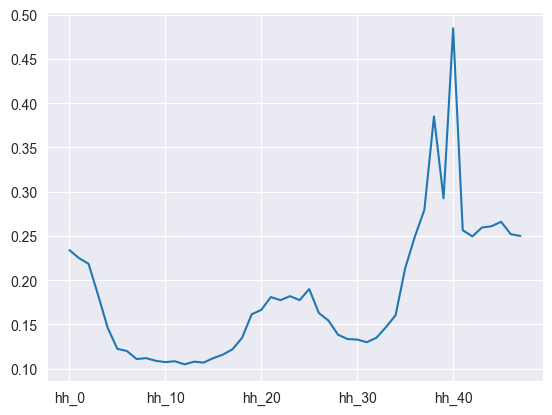

In [82]:
df.set_index(['LCLid', 'day']).xs(lcl_ids[0], level=0).median().plot()

<Axes: >

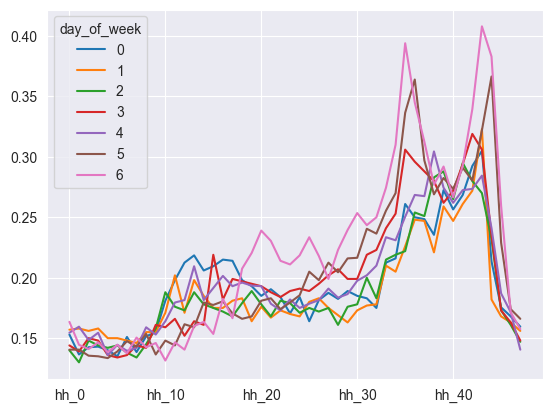

In [80]:
df.set_index(['LCLid', 'day']).xs(lcl_ids[1], level=0).reset_index().assign(
    day_of_week=lambda x: x['day'].dt.dayofweek
).drop(columns=['day']).groupby('day_of_week').median().T.plot()